In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_path = "Datasets\solar_sensor_data.csv" 
sensor_df = pd.read_csv(file_path)

In [3]:
test_file_path = "Datasets\weather_sensor_data.csv"
weather_df = pd.read_csv(test_file_path)

In [4]:
pd.set_option('display.float_format', '{:.6f}'.format)

In [5]:
sensor_df

,LOCATION,DATE_TIME,SENSOR_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,A,15-05-2020 00:00,sensor 1,0.000000,0.000000,0.000000,6259559.000000
1,A,15-05-2020 00:00,sensor 2,0.000000,0.000000,0.000000,6183645.000000
2,A,15-05-2020 00:00,sensor 3,0.000000,0.000000,0.000000,6987759.000000
3,A,15-05-2020 00:00,sensor 5,0.000000,0.000000,0.000000,7602960.000000
4,A,15-05-2020 00:00,sensor 12,0.000000,0.000000,0.000000,7158964.000000
...,...,...,...,...,...,...,...
136471,B,2020-06-17 23:45:00,sensor 33,0.000000,0.000000,4157.000000,520758.000000
136472,B,2020-06-17 23:45:00,sensor 35,0.000000,0.000000,3931.000000,121131356.000000
136473,B,2020-06-17 23:45:00,sensor 38,0.000000,0.000000,4322.000000,2427691.000000
136474,B,2020-06-17 23:45:00,sensor 40,0.000000,0.000000,4218.000000,106896394.000000


In [6]:
weather_df

,LOCATION,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,A,2020-05-15 00:00:00,25.184316,22.857507,0.000000
1,A,2020-05-15 00:15:00,25.084589,22.761668,0.000000
2,A,2020-05-15 00:30:00,24.935753,22.592306,0.000000
3,A,2020-05-15 00:45:00,24.846130,22.360852,0.000000
4,A,2020-05-15 01:00:00,24.621525,22.165423,0.000000
...,...,...,...,...,...
6436,B,2020-06-17 22:45:00,23.511703,22.856201,0.000000
6437,B,2020-06-17 23:00:00,23.482282,22.744190,0.000000
6438,B,2020-06-17 23:15:00,23.354743,22.492245,0.000000
6439,B,2020-06-17 23:30:00,23.291048,22.373909,0.000000


In [7]:
def customDescription(df: pd.DataFrame, numeric_only: bool = False):
    if numeric_only:
        df = df.select_dtypes(include=np.number)
    
    desc = pd.DataFrame(index=df.columns.to_list())
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['null'] = df.isnull().sum()
    
    # Handle numeric columns separately
    if not df.select_dtypes(include=np.number).empty:
        numeric_desc = df.describe().T.drop(columns=['count','std','25%','50%','75%'], axis=1)
        for col in df.select_dtypes(include=np.number).columns:
            desc.loc[col, 'mean'] = numeric_desc.loc[col, 'mean']
            desc.loc[col, 'min'] = numeric_desc.loc[col, 'min']
            desc.loc[col, 'max'] = numeric_desc.loc[col, 'max']
    
    # Handle non-numeric columns separately
    if not df.select_dtypes(exclude=np.number).empty:
        non_numeric_desc = df.select_dtypes(exclude=np.number).describe().T
        desc = pd.concat([desc, non_numeric_desc.drop(columns=['count', 'unique', 'top', 'freq'], axis=1, errors='ignore')], axis=1)
    
    return desc

In [8]:
customDescription(sensor_df)

,type,count,nunique,null,mean,min,max
LOCATION,object,136476,2,0,NaN,NaN,NaN
DATE_TIME,object,136476,6417,0,NaN,NaN,NaN
SENSOR_ID,object,136476,44,0,NaN,NaN,NaN
DC_POWER,float64,136476,63581,0,1708.541497,0.000000,14471.125000
AC_POWER,float64,136476,62872,0,274.803511,0.000000,1410.950000
DAILY_YIELD,float64,136476,59249,0,3295.433783,0.000000,9873.000000
TOTAL_YIELD,float64,136476,70381,0,330382090.068492,0.000000,2247916295.000000


In [9]:
customDescription(weather_df)

,type,count,nunique,null,mean,min,max
LOCATION,object,6441,2,0,NaN,NaN,NaN
DATE_TIME,object,6441,3262,0,NaN,NaN,NaN
AMBIENT_TEMPERATURE,float64,6441,6441,0,26.815672,20.398505,39.181638
MODULE_TEMPERATURE,float64,6441,6441,0,31.941762,18.140415,66.635953
IRRADIATION,float64,6441,3620,0,0.230551,0.000000,1.221652


In [10]:
# Convert DATE_TIME to the desired format only where LOCATION is "A"
sensor_df.loc[sensor_df['LOCATION'] == "A", 'DATE_TIME'] = pd.to_datetime(
    sensor_df.loc[sensor_df['LOCATION'] == "A", 'DATE_TIME'], 
    format='%d-%m-%Y %H:%M'
).dt.strftime('%Y-%m-%d %H:%M:%S')

In [11]:
# Merge the sensor and weather DataFrames on LOCATION and DATE_TIME
merged_df = pd.merge(sensor_df, weather_df, on=["LOCATION", "DATE_TIME"], how="left")

In [12]:
# Split the DataFrame into two based on LOCATION
df_A = merged_df[merged_df['LOCATION'] == "A"].reset_index(drop=True)
df_B = merged_df[merged_df['LOCATION'] == "B"].reset_index(drop=True)

In [35]:
df_A[df_A['SENSOR_ID'] == "sensor 1"].head(96)
# df_A

,LOCATION,DATE_TIME,DATE,TIME,SENSOR_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,A,2020-05-15 00:00:00,2020-05-15,00:00:00,sensor 1,0.000000,0.000000,0.000000,6259559.000000,25.184316,22.857507,0.000000
21,A,2020-05-15 00:15:00,2020-05-15,00:15:00,sensor 1,0.000000,0.000000,0.000000,6259559.000000,25.084589,22.761668,0.000000
42,A,2020-05-15 00:30:00,2020-05-15,00:30:00,sensor 1,0.000000,0.000000,0.000000,6259559.000000,24.935753,22.592306,0.000000
63,A,2020-05-15 00:45:00,2020-05-15,00:45:00,sensor 1,0.000000,0.000000,0.000000,6259559.000000,24.846130,22.360852,0.000000
84,A,2020-05-15 01:00:00,2020-05-15,01:00:00,sensor 1,0.000000,0.000000,0.000000,6259559.000000,24.621525,22.165423,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1910,A,2020-05-15 22:45:00,2020-05-15,22:45:00,sensor 1,0.000000,0.000000,5754.000000,6265313.000000,22.057080,21.072276,0.000000
1932,A,2020-05-15 23:00:00,2020-05-15,23:00:00,sensor 1,0.000000,0.000000,5754.000000,6265313.000000,22.236018,21.241317,0.000000
1954,A,2020-05-16 02:00:00,2020-05-16,02:00:00,sensor 1,0.000000,0.000000,0.000000,6265313.000000,21.682160,20.072144,0.000000
1974,A,2020-05-16 02:15:00,2020-05-16,02:15:00,sensor 1,0.000000,0.000000,0.000000,6265313.000000,21.688411,19.919204,0.000000


In [14]:
df_B[df_B['SENSOR_ID'] == "sensor 4"].head(247)
# df_B

,LOCATION,DATE_TIME,SENSOR_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,B,2020-05-15 00:00:00,sensor 4,0.000000,0.000000,9425.000000,2429011.000000,27.004764,25.060789,0.000000
22,B,2020-05-15 00:15:00,sensor 4,0.000000,0.000000,9425.000000,2429011.000000,26.880811,24.421869,0.000000
44,B,2020-05-15 00:30:00,sensor 4,0.000000,0.000000,9425.000000,2429011.000000,26.682055,24.427290,0.000000
66,B,2020-05-15 00:45:00,sensor 4,0.000000,0.000000,9425.000000,2429011.000000,26.500589,24.420678,0.000000
88,B,2020-05-15 01:00:00,sensor 4,0.000000,0.000000,7540.000000,2429011.000000,26.596148,25.088210,0.000000
...,...,...,...,...,...,...,...,...,...,...
5324,B,2020-05-17 12:45:00,sensor 4,0.000000,0.000000,3940.000000,2442829.000000,34.646782,51.270622,0.715616
5346,B,2020-05-17 13:00:00,sensor 4,0.000000,0.000000,3940.000000,2442829.000000,35.030951,53.760645,0.754738
5368,B,2020-05-17 13:15:00,sensor 4,0.000000,0.000000,3152.000000,1954263.200000,35.524103,56.541869,0.799829
5390,B,2020-05-17 13:30:00,sensor 4,436.920000,427.353333,1597.466667,1954284.666667,36.103419,59.100530,0.688748


In [15]:
customDescription(df_A)

,type,count,nunique,null,mean,min,max
LOCATION,object,68778,1,0,NaN,NaN,NaN
DATE_TIME,object,68778,3158,0,NaN,NaN,NaN
SENSOR_ID,object,68778,22,0,NaN,NaN,NaN
DC_POWER,float64,68778,32909,0,3147.426211,0.000000,14471.125000
AC_POWER,float64,68778,32686,0,307.802752,0.000000,1410.950000
DAILY_YIELD,float64,68778,29900,0,3295.968737,0.000000,9163.000000
TOTAL_YIELD,float64,68778,37267,0,6978711.760671,6183645.000000,7846821.000000
AMBIENT_TEMPERATURE,float64,68774,3157,4,25.558521,20.398505,35.252486
MODULE_TEMPERATURE,float64,68774,3157,4,31.244997,18.140415,65.545714
IRRADIATION,float64,68774,1755,4,0.232305,0.000000,1.221652


In [16]:
customDescription(df_B)

,type,count,nunique,null,mean,min,max
LOCATION,object,67698,1,0,NaN,NaN,NaN
DATE_TIME,object,67698,3259,0,NaN,NaN,NaN
SENSOR_ID,object,67698,22,0,NaN,NaN,NaN
DC_POWER,float64,67698,30799,0,246.701961,0.000000,1420.933333
AC_POWER,float64,67698,30744,0,241.277825,0.000000,1385.420000
DAILY_YIELD,float64,67698,30432,0,3294.890295,0.000000,9873.000000
TOTAL_YIELD,float64,67698,33114,0,658944788.423766,0.000000,2247916295.000000
AMBIENT_TEMPERATURE,float64,67698,3259,0,27.986756,20.942385,39.181638
MODULE_TEMPERATURE,float64,67698,3259,0,32.607233,20.265123,66.635953
IRRADIATION,float64,67698,1863,0,0.229204,0.000000,1.098766


In [17]:
df_A_null_temp = df_A[df_A['AMBIENT_TEMPERATURE'].isnull()]
df_A_null_temp

,LOCATION,DATE_TIME,SENSOR_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
38544,A,2020-06-03 14:00:00,sensor 2,7003.000000,685.800000,5601.000000,6330385.000000,NaN,NaN,NaN
38545,A,2020-06-03 14:00:00,sensor 25,7204.000000,705.400000,5685.000000,6419961.000000,NaN,NaN,NaN
38546,A,2020-06-03 14:00:00,sensor 39,7545.000000,738.700000,5579.000000,6928448.000000,NaN,NaN,NaN
38547,A,2020-06-03 14:00:00,sensor 42,7946.000000,777.800000,5541.000000,7152815.000000,NaN,NaN,NaN


In [18]:
df_A['DATE_TIME'] = pd.to_datetime(df_A['DATE_TIME'])
df_A['DATE'] = df_A['DATE_TIME'].dt.date
df_A['DATE'] = pd.to_datetime(df_A['DATE'], format='%Y-%m-%d')
df_A['TIME'] = df_A['DATE_TIME'].dt.time
# df_A.drop(columns=['DATE_TIME'], inplace=True)
df_A = df_A[['LOCATION', 'DATE_TIME', 'DATE', 'TIME', 'SENSOR_ID', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]

df_B['DATE_TIME'] = pd.to_datetime(df_B['DATE_TIME'])
df_B['DATE'] = df_B['DATE_TIME'].dt.date
df_B['DATE'] = pd.to_datetime(df_B['DATE'], format='%Y-%m-%d')
df_B['TIME'] = df_B['DATE_TIME'].dt.time
# df_B.drop(columns=['DATE_TIME'], inplace=True)
df_B = df_B[['LOCATION', 'DATE_TIME', 'DATE', 'TIME', 'SENSOR_ID', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]

In [38]:
df_A.to_csv("Datasets\df_A.csv", index=False)
df_B.to_csv("Datasets\df_B.csv", index=False)

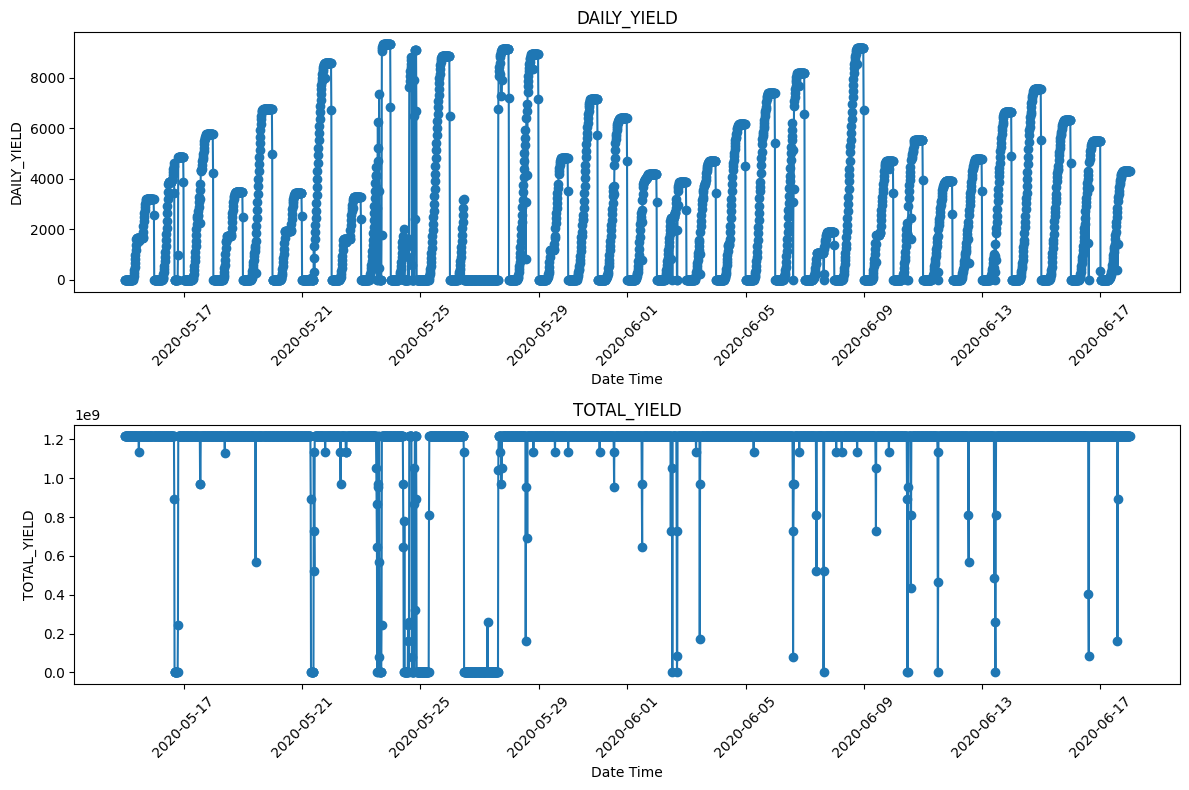

In [30]:
# Filter the DataFrame for sensor 1
sensor_1_df = df_B[(df_B['SENSOR_ID'] == 'sensor 6')]

# Set up the plotting figure
plt.figure(figsize=(12, 8))

# Plot each feature with DATE_TIME on the x-axis
features = ['DAILY_YIELD', 'TOTAL_YIELD']

for i, feature in enumerate(features, 1):
    plt.subplot(2, 1, i)  # Create subplots (3x3 grid)
    plt.plot(sensor_1_df['DATE_TIME'], sensor_1_df[feature], marker='o')
    plt.title(feature)
    plt.xlabel('Date Time')
    plt.xticks(rotation=45)
    plt.ylabel(feature)

# Adjust the layout for better spacing
plt.tight_layout()
plt.show()

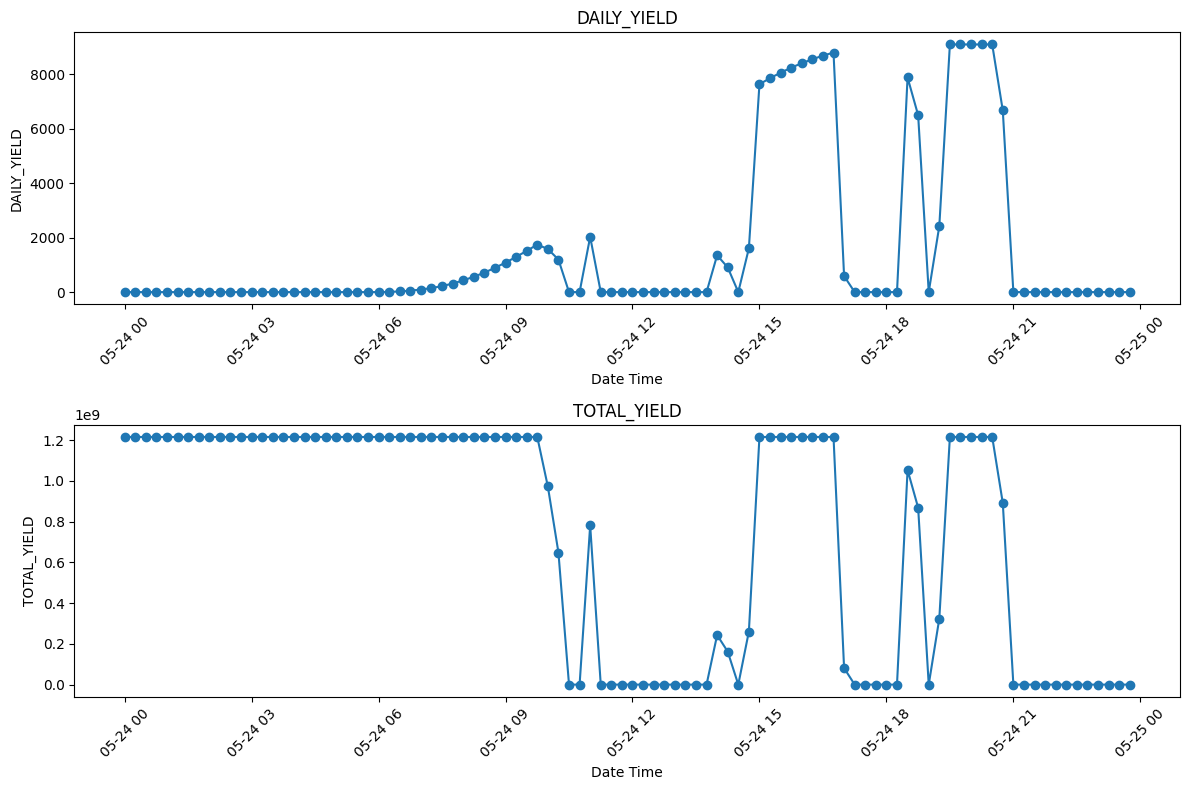

In [31]:
# Filter the DataFrame for sensor 1
sensor_1_df = df_B[(df_B['SENSOR_ID'] == 'sensor 6') & (df_B['DATE'] == '2020-05-24')]

# Set up the plotting figure
plt.figure(figsize=(12, 8))

# Plot each feature with DATE_TIME on the x-axis
features = ['DAILY_YIELD', 'TOTAL_YIELD']

for i, feature in enumerate(features, 1):
    plt.subplot(2, 1, i)  # Create subplots (3x3 grid)
    plt.plot(sensor_1_df['DATE_TIME'], sensor_1_df[feature], marker='o')
    plt.title(feature)
    plt.xlabel('Date Time')
    plt.xticks(rotation=45)
    plt.ylabel(feature)

# Adjust the layout for better spacing
plt.tight_layout()
plt.show()